In [ ]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from PIL import Image

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [ ]:
path = r"/content/Images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
curves = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the curves list
            curves.append(file.name)

In [ ]:
curves = sorted(curves, key=lambda x: int(os.path.splitext(x)[0]))
print(curves)

['1.png', '2.png', '3.png', '4.png', '5.png']


Zkusíme osekat ty obrázky tak, aby tam byl pouze ten obdélník mající *peak* point + krátký kus k tomu.

In [ ]:
img = Image.open('/content/Images/1.png')
crop_coordinates = (2400*0.15, 0, 4260*0.25, 2200)
cropped_img = img.crop(crop_coordinates)
cropped_img.save('/content/Images/cropped_1.png')

In [ ]:
# load the image as a 224x224 array
img = load_img(curves[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)

(224, 224, 3)


In [ ]:
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [ ]:
x = preprocess_input(reshaped_img)

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

553467096/553467096 [==============================] - 18s 0us/step


In [ ]:
data = {}
p = r"/content/Images/Vectors"

# lop through each image in the dataset
for curve in curves:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(curve,model)
        data[curve] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)


1/1 [==============================] - 1s 942ms/step


In [ ]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)


In [ ]:
curves = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
    # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
            # adds only the image files to the curves list
            curves.append(file.name)

# Extract the numeric part and convert to integers
numeric_parts = [int(os.path.splitext(curve)[0]) for curve in curves]

# Sort the numeric parts
unique_labels = sorted(numeric_parts)


In [ ]:
unique_labels[0:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=50, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters= 3, n_init = 'auto', random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:10]
    # plot each image in the cluster
    num_files = len(files)
    num_rows = int(num_files ** 0.5) + 1  # Add 1 to ensure all images are shown
    num_cols = num_files // num_rows + (num_files % num_rows > 0)
    for index, file in enumerate(files):
        plt.subplot(num_rows, num_cols, index + 1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')


Clipping cluster size from 61 to 15
Clipping cluster size from 67 to 15
Clipping cluster size from 41 to 15


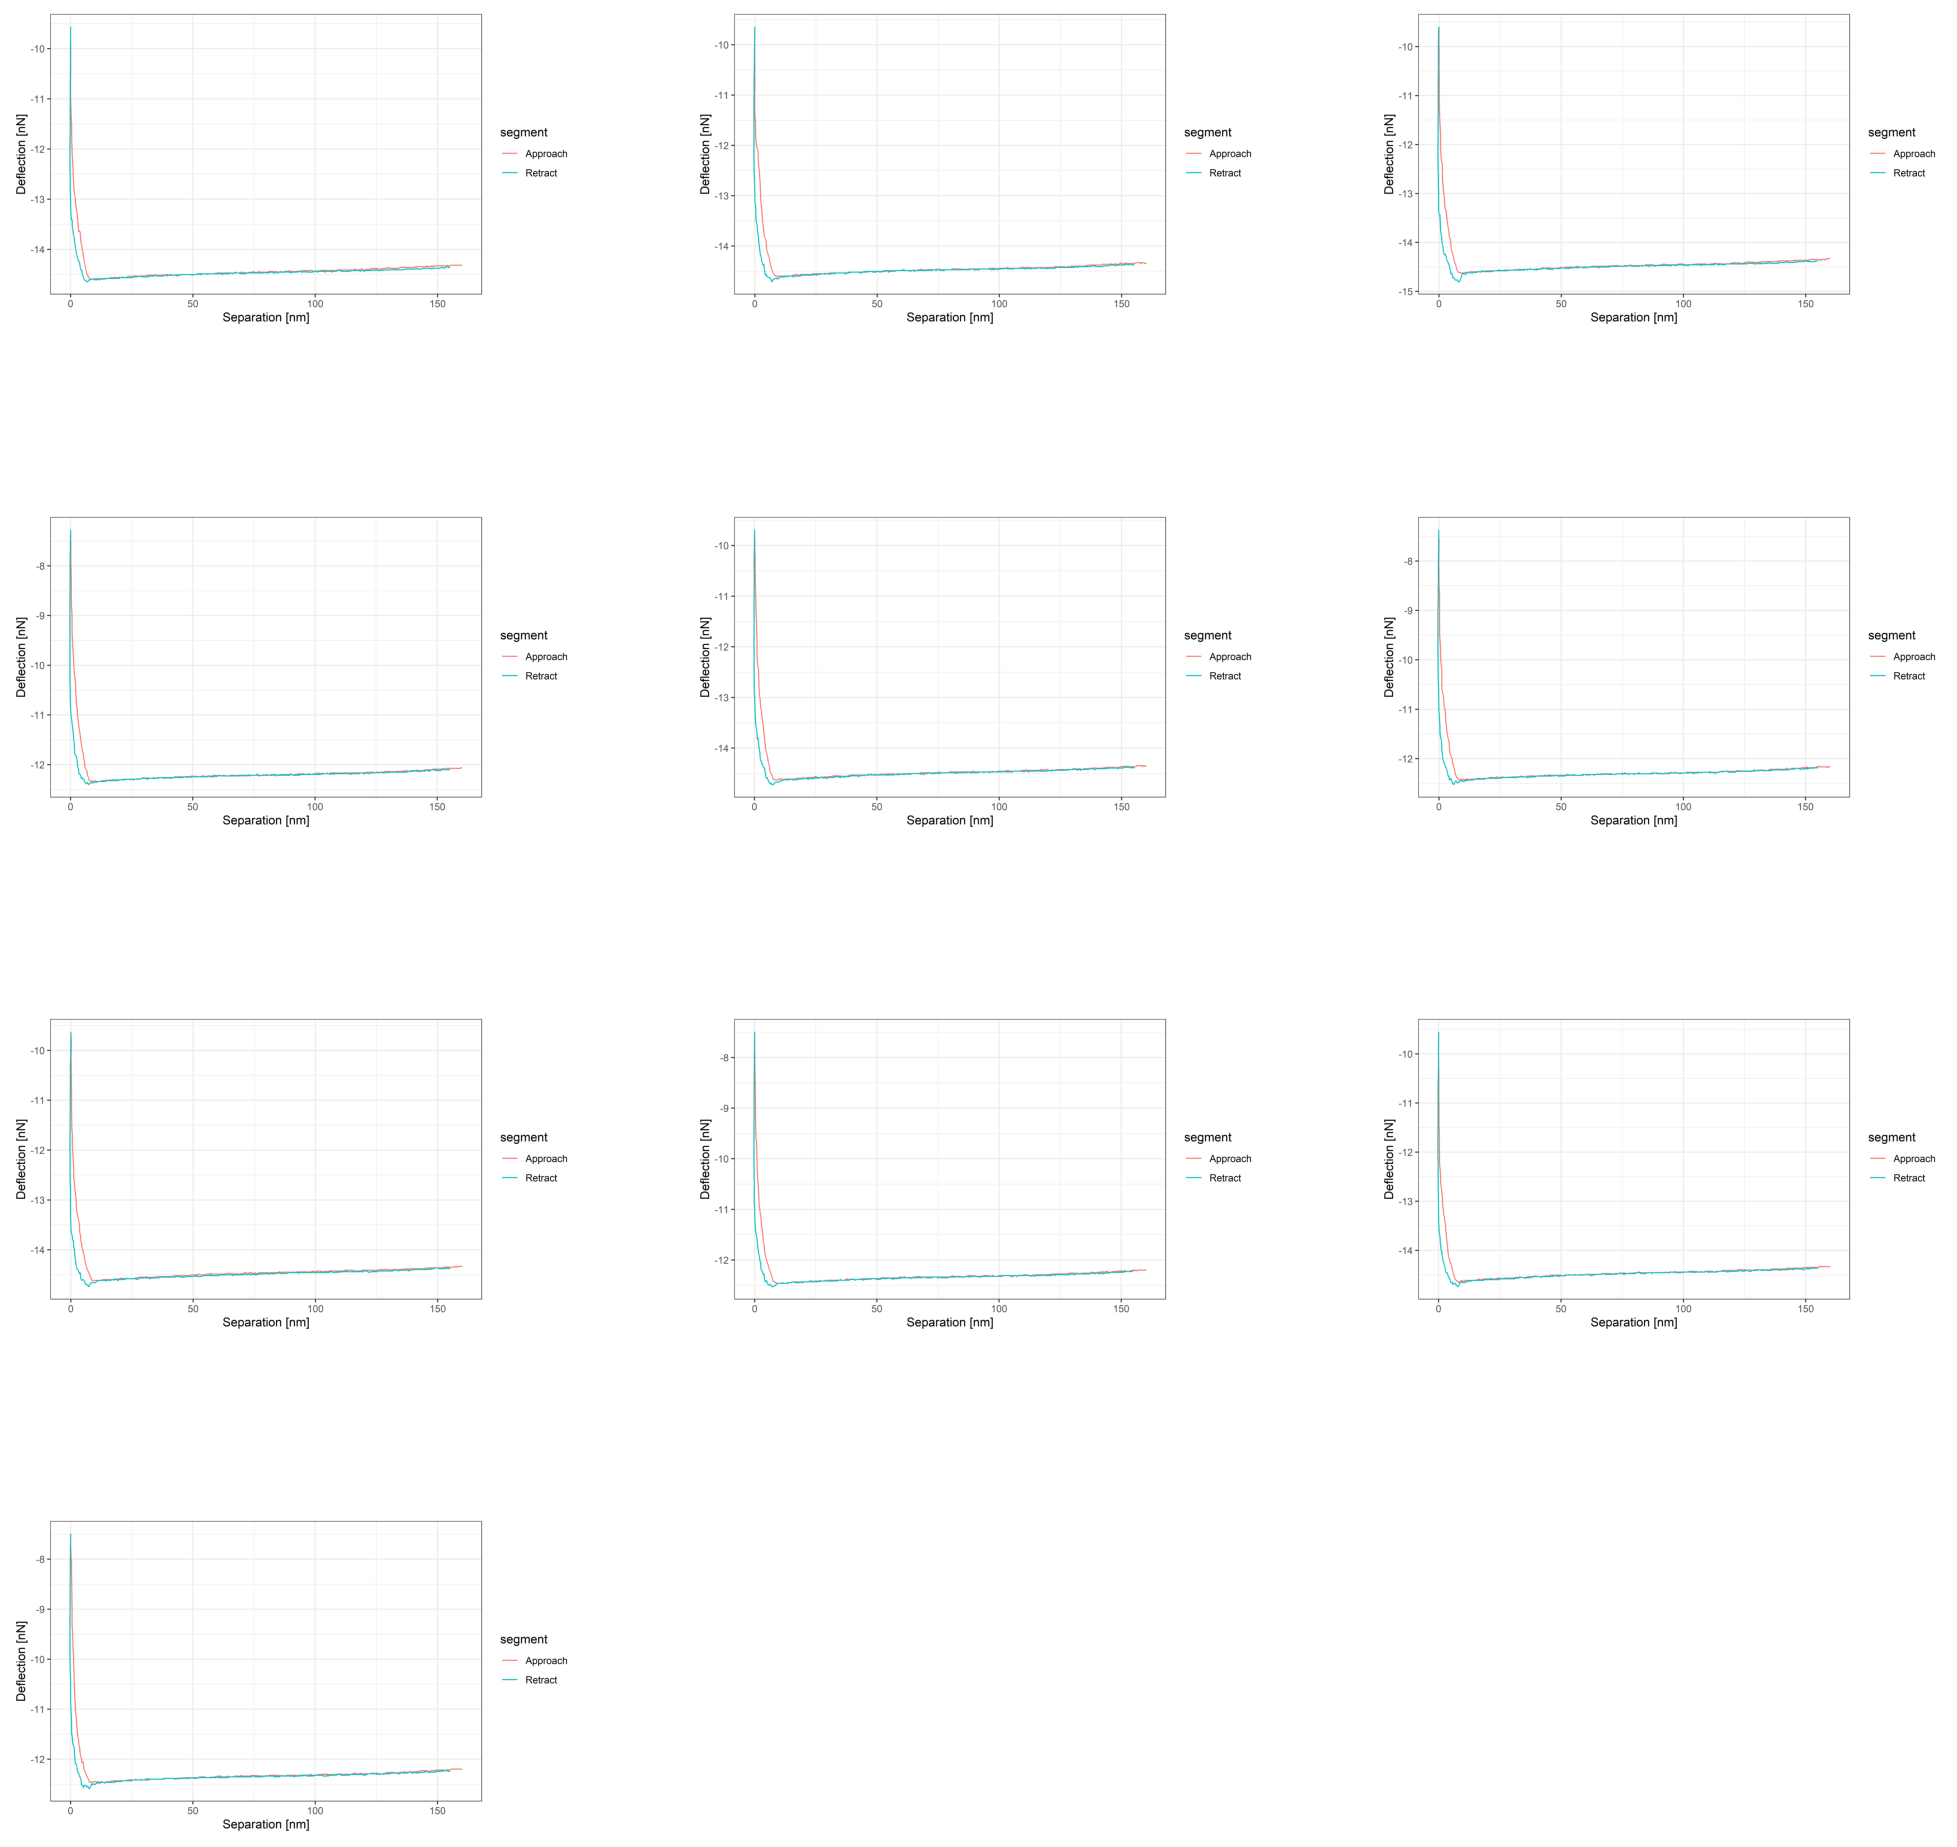

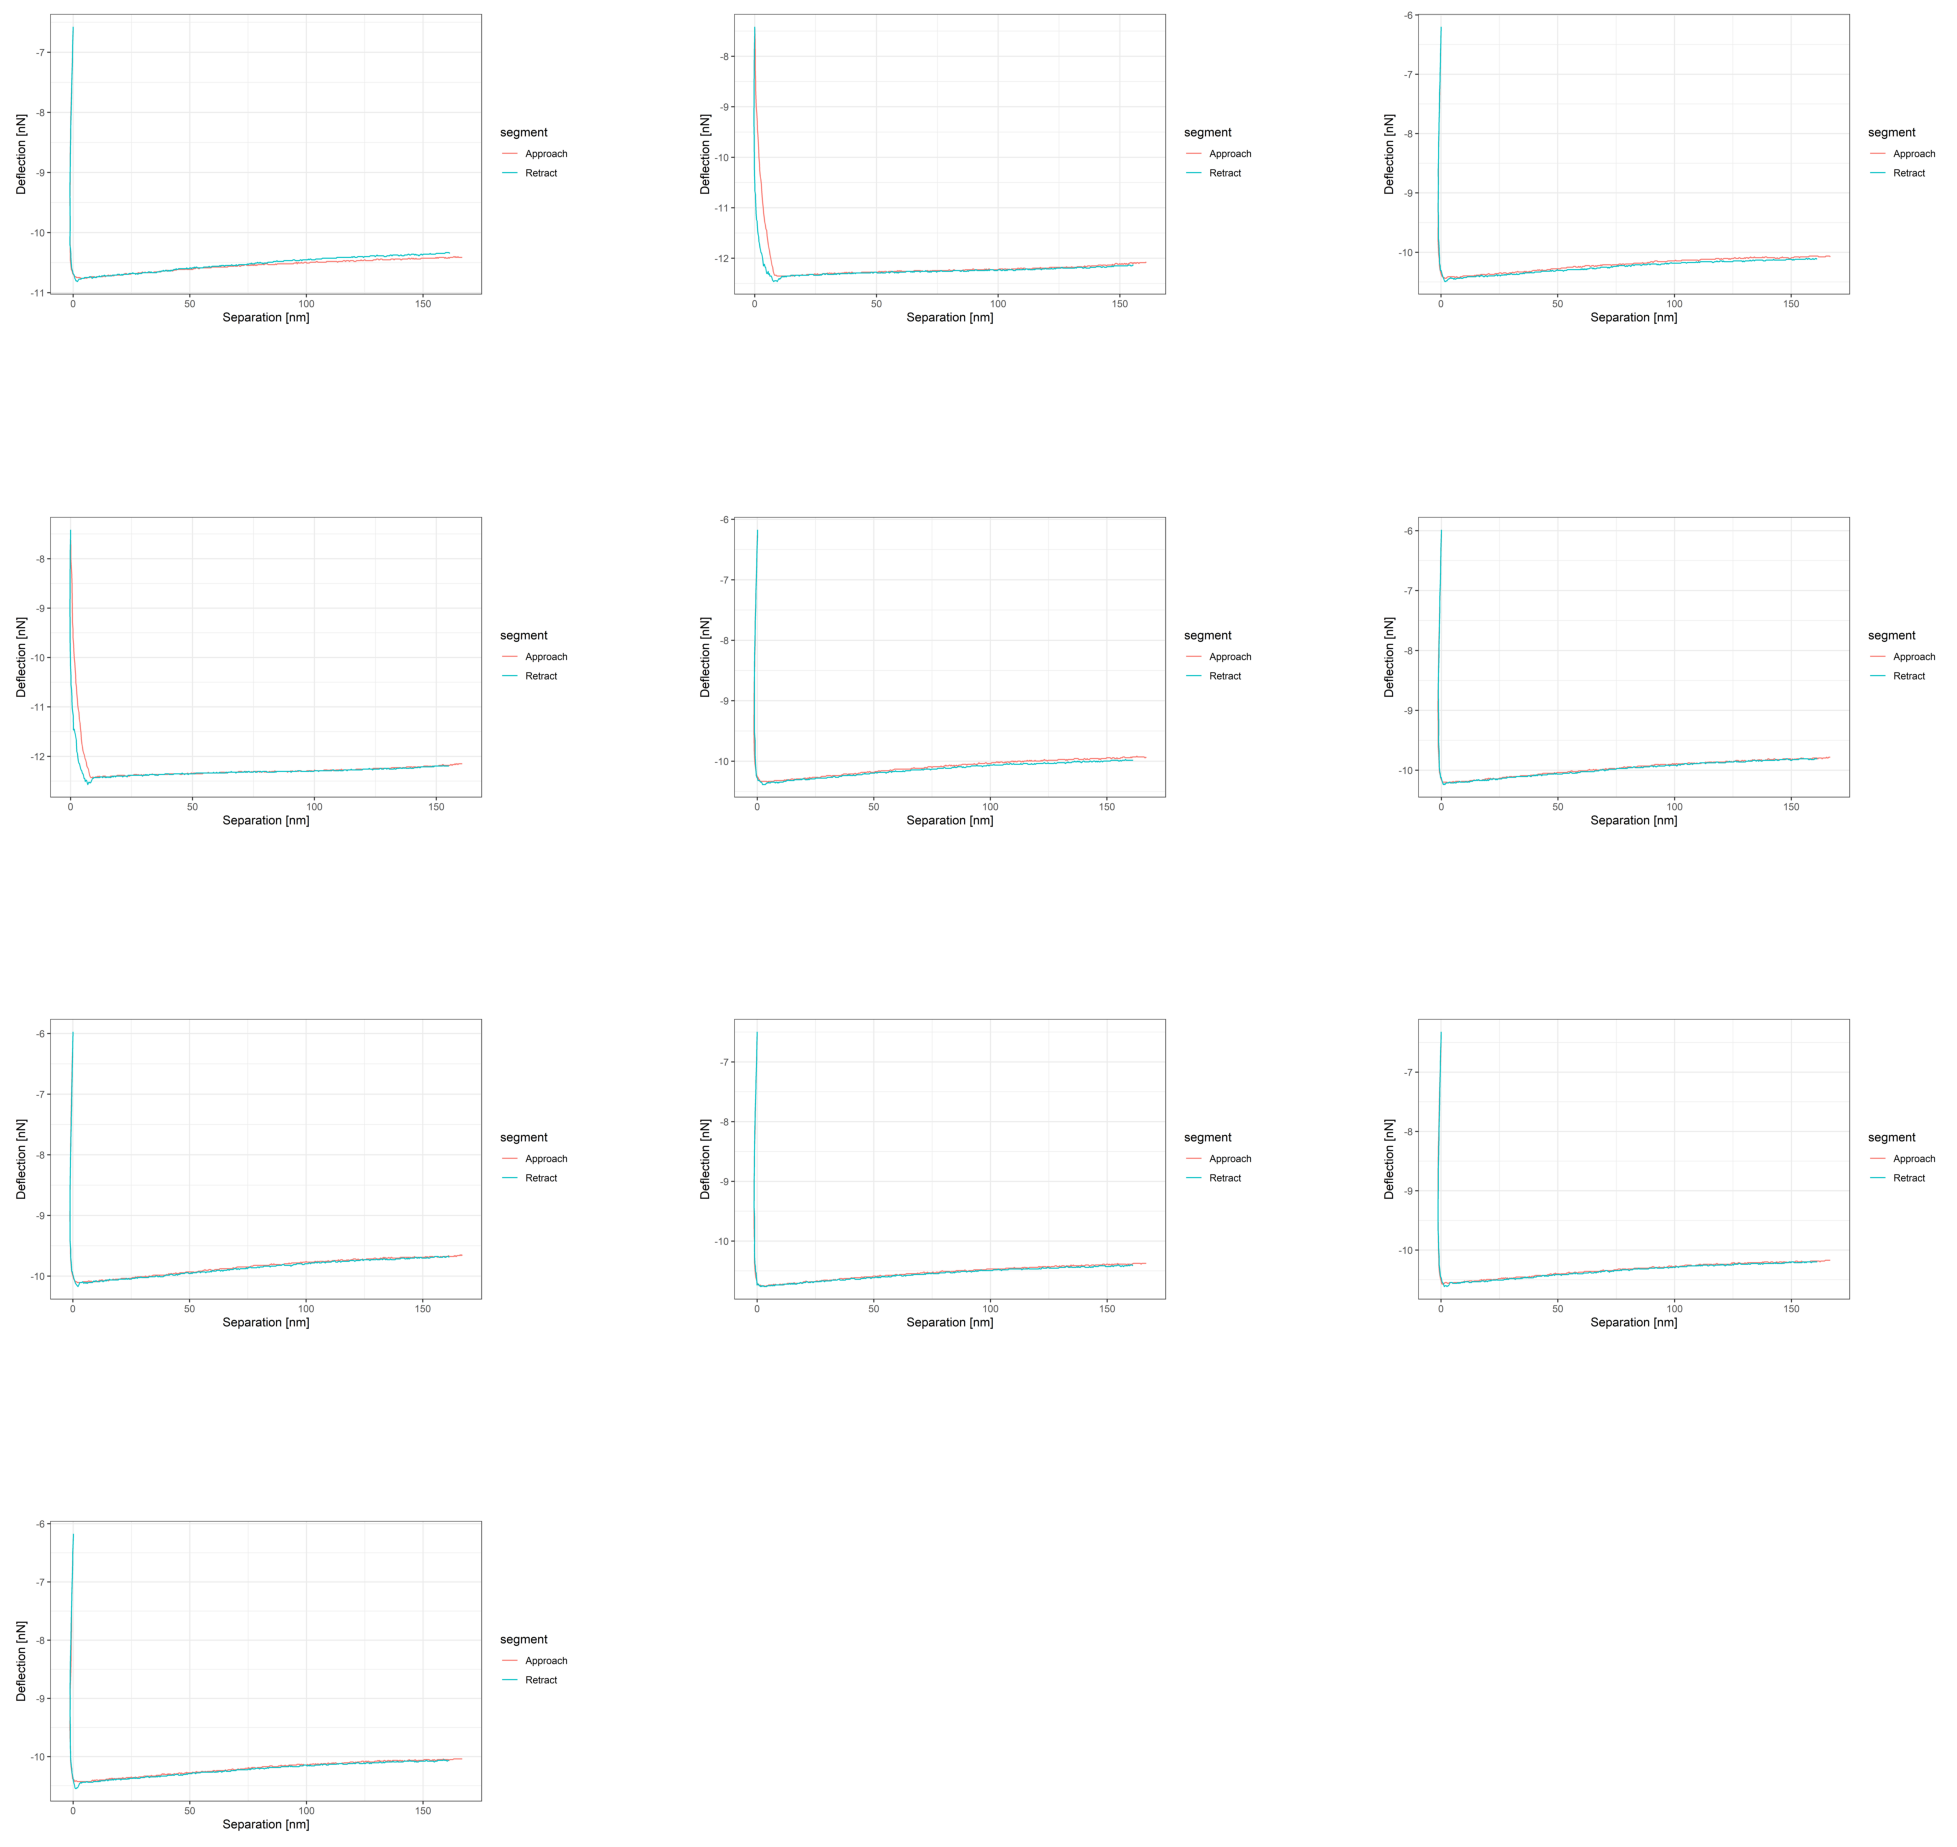

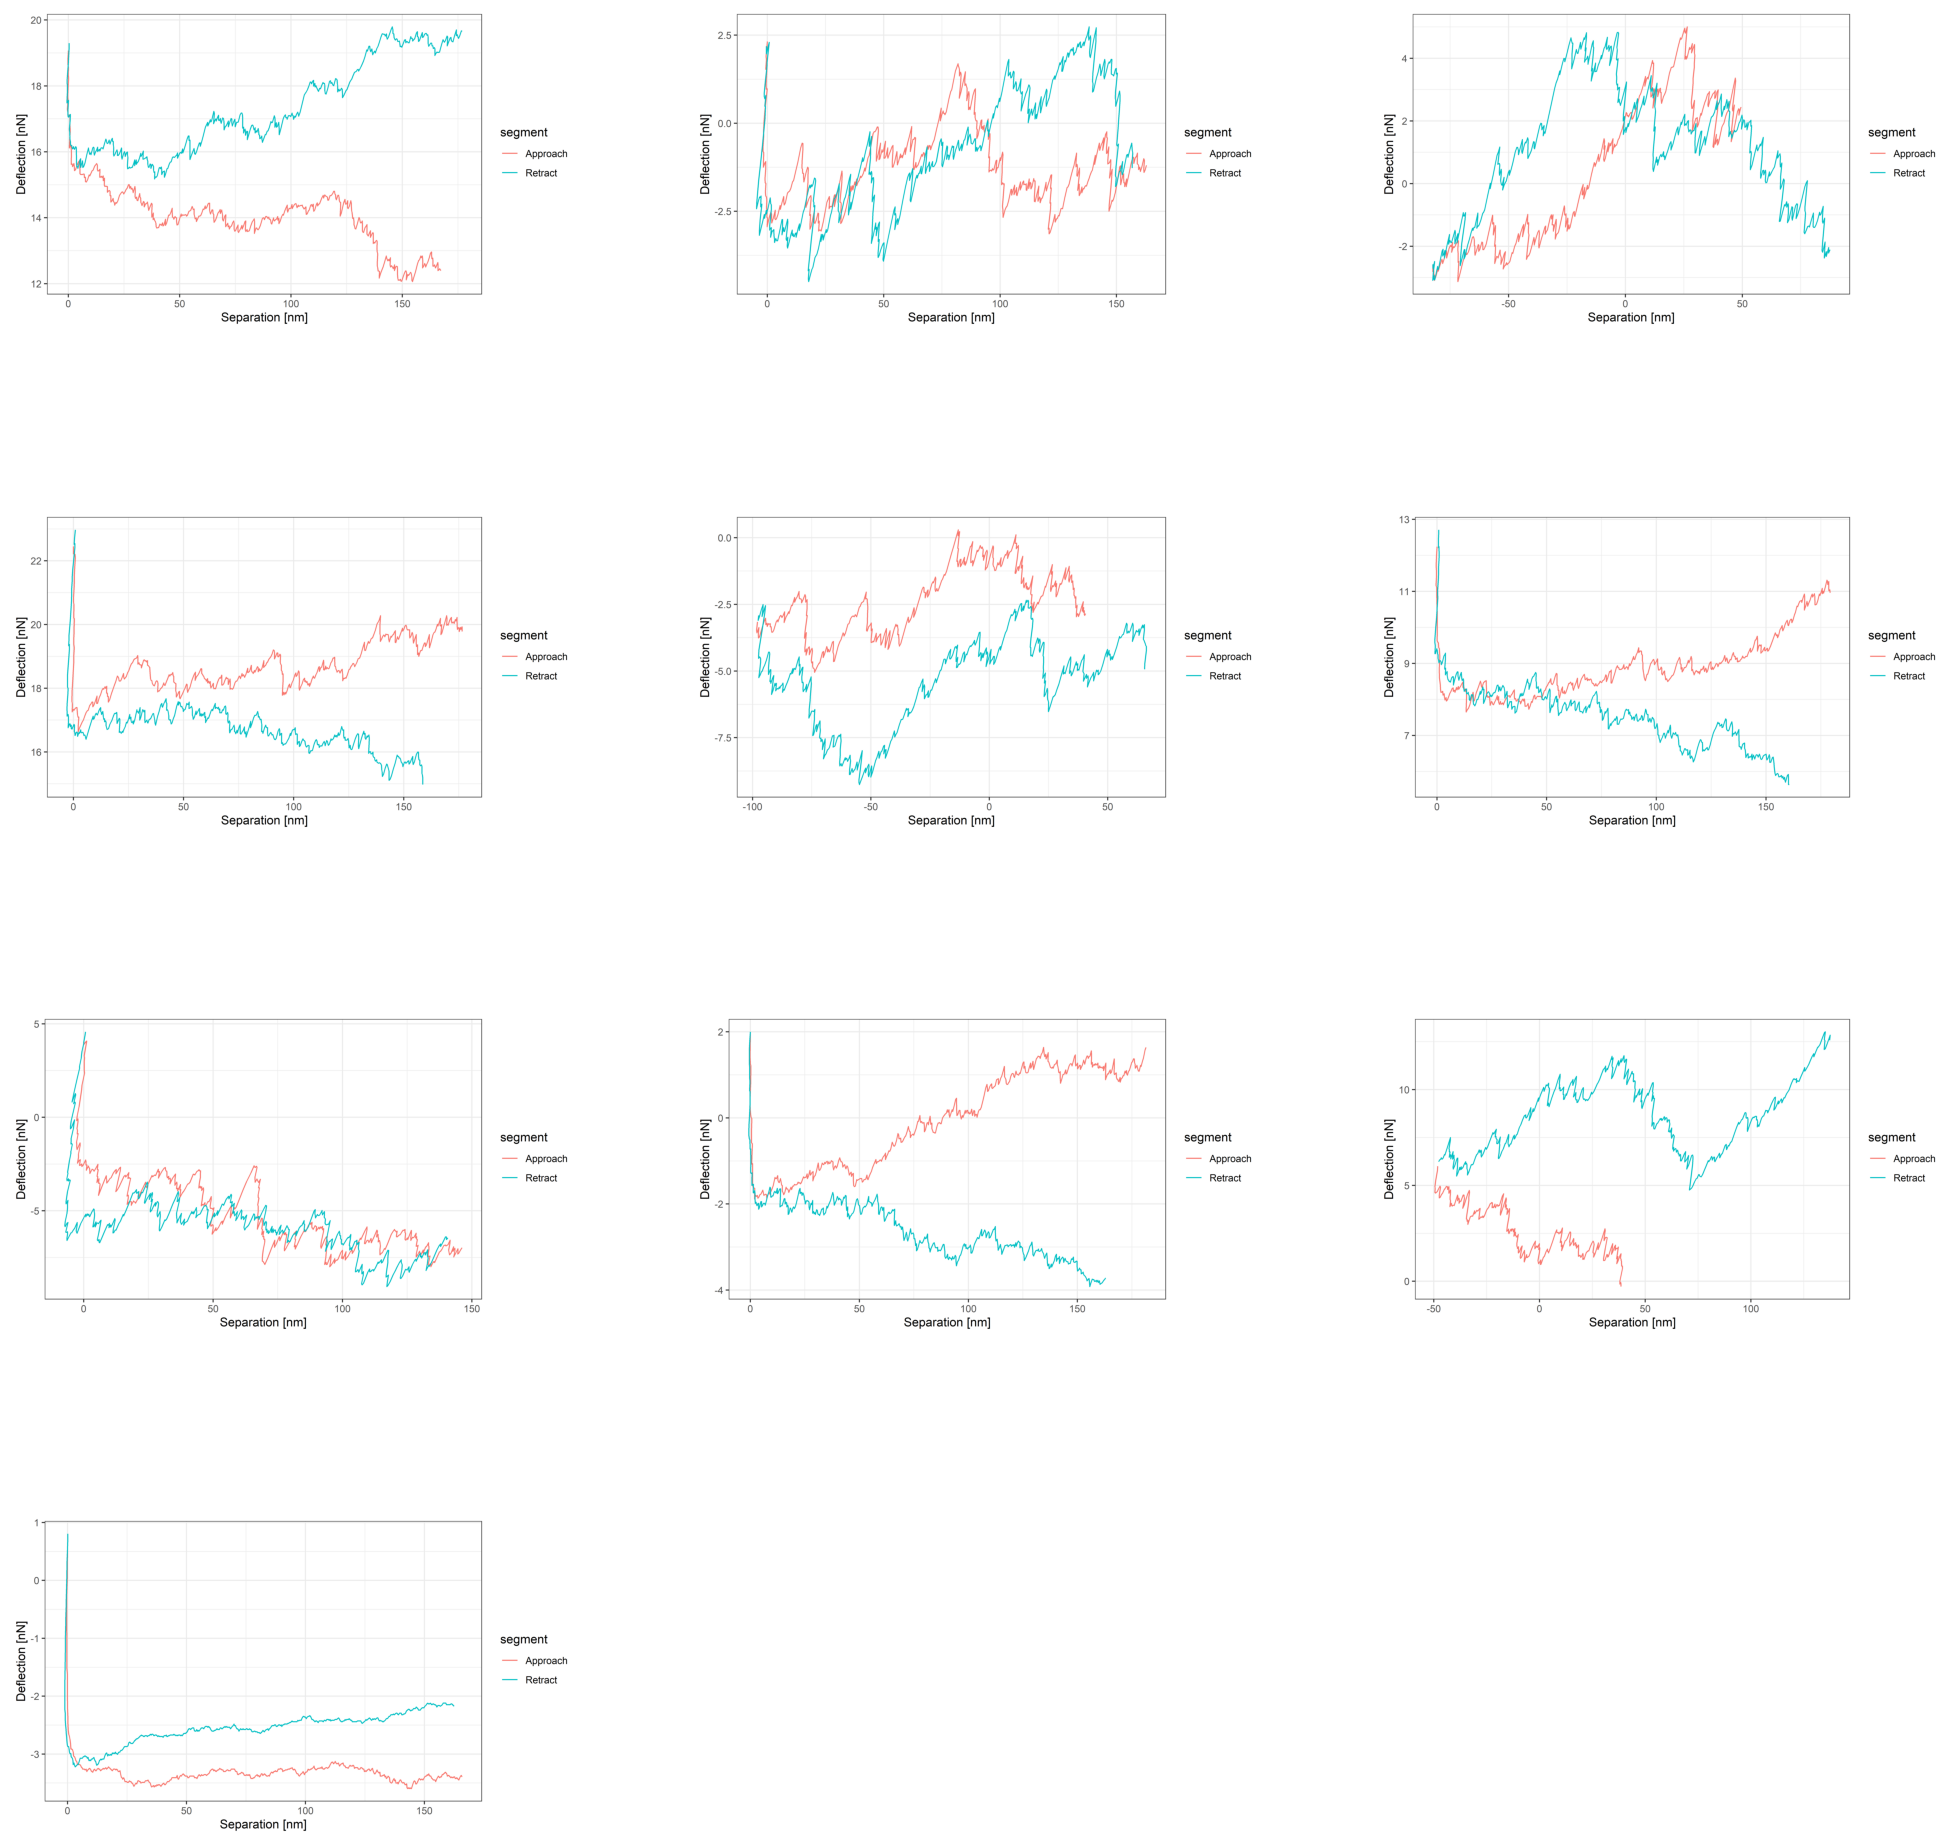

In [ ]:
for cluster in groups.keys():
    view_cluster(cluster)

plt.show()